# Data Exploration
The aim of this part of our ML project workflow, is to get a good feel for the training data. Note, that **we explicitly forbid ourselves from looking at the test data**, so that when we test our final candidate model on it, it is mimicking the process of experiencing new data in a 'production like' environment.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv('data/housing_train.csv')

## Data Quality
Looking specifically for missing data.

In [5]:
train_data.info()

print('\ncolumns/variables with any null/missing observations:')
train_data.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16351 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.3+ MB

columns/variables with any null/missing observations:


longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

The above output points to missing data for `total_bedrooms` that will have to be imputed as part of the data preparation pipeline that we will construct in the 'Data Preparation Pipeline' part our ML project workflow.

## Descriptive Statistics
Note, that these statistics do not include the null/missing observations as part of their calculation.

In [2]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16351.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.581770,35.642424,28.630329,2636.752604,538.542536,1426.378755,500.153464,3.863453,206783.719174
std,2.002865,2.134789,12.597979,2165.204201,417.194866,1093.752716,378.300907,1.887172,115375.265572
min,-124.350000,32.540000,1.000000,2.000000,2.000000,5.000000,2.000000,0.499900,14999.000000
25%,-121.810000,33.940000,18.000000,1449.000000,296.000000,787.000000,280.000000,2.560300,119900.000000
50%,-118.510000,34.260000,29.000000,2127.000000,435.000000,1166.000000,410.000000,3.534800,179500.000000
75%,-118.010000,37.720000,37.000000,3158.000000,651.000000,1729.000000,607.000000,4.738600,264400.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


## Distributions
Looking at the types of dispersion (i.e. for signs of skew or kurtosis), possible bi/multi-modality and anything 'odd'.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111be5278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11589bfd0>]], dtype=object)

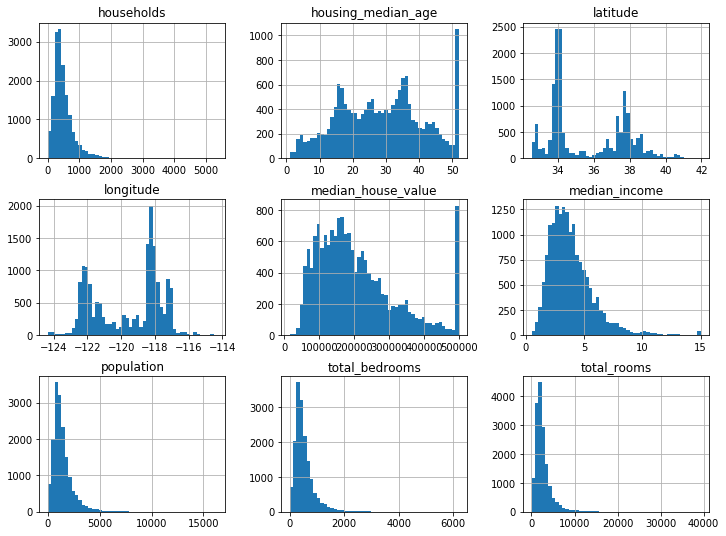

In [3]:
data.hist(bins=50, figsize=(12, 9))

From which we can see that `longitude` and `latitude` are bi-modal, `median_housing_age` and `median_housing_value` appear to have been capped (they ought to to be 'cleaned' or dealt with in some way), and that all other distributions appear to be log-normally distributed.

Given what I can see here, my intuition tells me that a tree-based model that can handle the bi-modalities through its ability to split the variables via its recursive partitioning strategy, might be a good model to consider. Linear regression is likely to struggle with this as it's hard to see how a linear combination random variables with the distributions shown above, could lead to the distribution of `median-house_values` that we see above.

## Correlations
A crude measure of what variables are the most co-dependent with `median_house_value`.

In [4]:
corr_matrix = data.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685886
total_rooms           0.136422
housing_median_age    0.104272
households            0.067724
total_bedrooms        0.053079
population           -0.024487
longitude            -0.043319
latitude             -0.146099
Name: median_house_value, dtype: float64

Perhaps unsurprisingly, it appears as if `median_income` displays some level of dependency with `median_house_value`. It may also be worth considering trying any candidate models without `housholds`, `total_bedrooms` and/or `population` variables.

## Scatter Matrices
Visualising dependency and structures between variables.

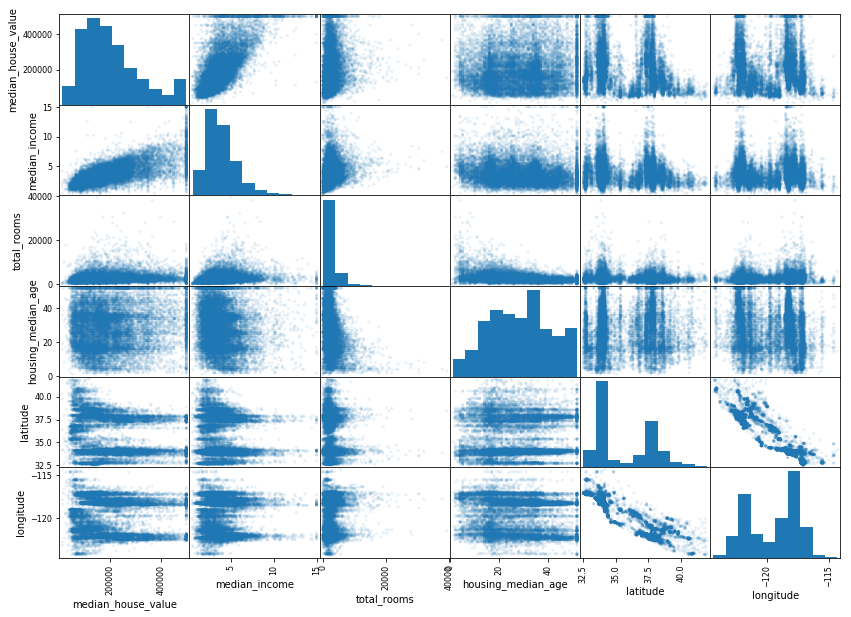

In [9]:
scatter_variables = [
    'median_house_value', 
    'median_income',
    'total_rooms',
    'housing_median_age',
    'latitude',
    'longitude'
]

splot = pd.plotting.scatter_matrix(
    train_data[scatter_variables], figsize=(14, 10), alpha=0.1)

This backs-up the comments I've made above - `median_income` appears to be the best (as well as the 'most normal') predictor for `median_house_value` and geospatial location also has an impact (although not with certainty).

## Geospatial Data
We now take a look at evidence for information content in the geospatial variables - `latitude` and `longitude`.

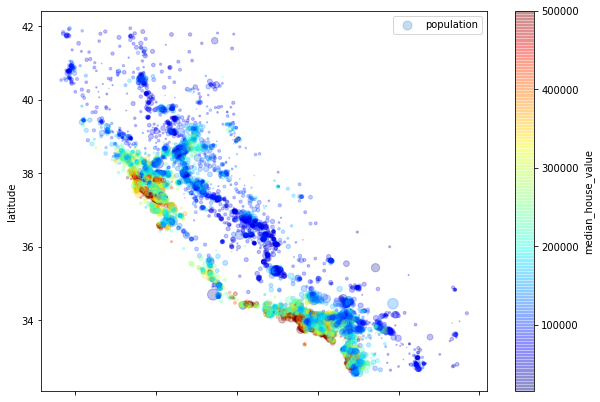

In [11]:
train_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.25,
         s=train_data['population']/100, label='population', figsize=(10,7),
         c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

We can see from the above, that median house prices are highest near the coast (of California) - that is, that there is likey information content (in the Shannon sense), in the geospatial variables, but no the sort that may work with any linear model, hence the low-ish levels of Pearson correlation (maybe we should have looked at something like the Spearman correlation coefficient instead).

## Derived Variables
We now consider features that can be derived from existing ones and repeat some of the above analyses.

In [15]:
train_data['rooms_per_household'] = train_data['total_rooms'] / train_data['households']
train_data['bedrooms_per_room'] = train_data['total_bedrooms'] / train_data['total_rooms']
train_data['bedrooms_per_room'] = train_data['total_bedrooms'] / train_data['total_rooms']

corr_matrix = train_data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.685886
rooms_per_household    0.147782
total_rooms            0.136422
housing_median_age     0.104272
households             0.067724
total_bedrooms         0.053079
population            -0.024487
longitude             -0.043319
latitude              -0.146099
bedrooms_per_room     -0.256558
Name: median_house_value, dtype: float64

From which we can see that `rooms_per_household` appears to have some co-dependency with `median_house_value`, so we *could* consider constructing this new feature as part of the data preparation pipeline we will work on in the next part of our example ML project workflow.

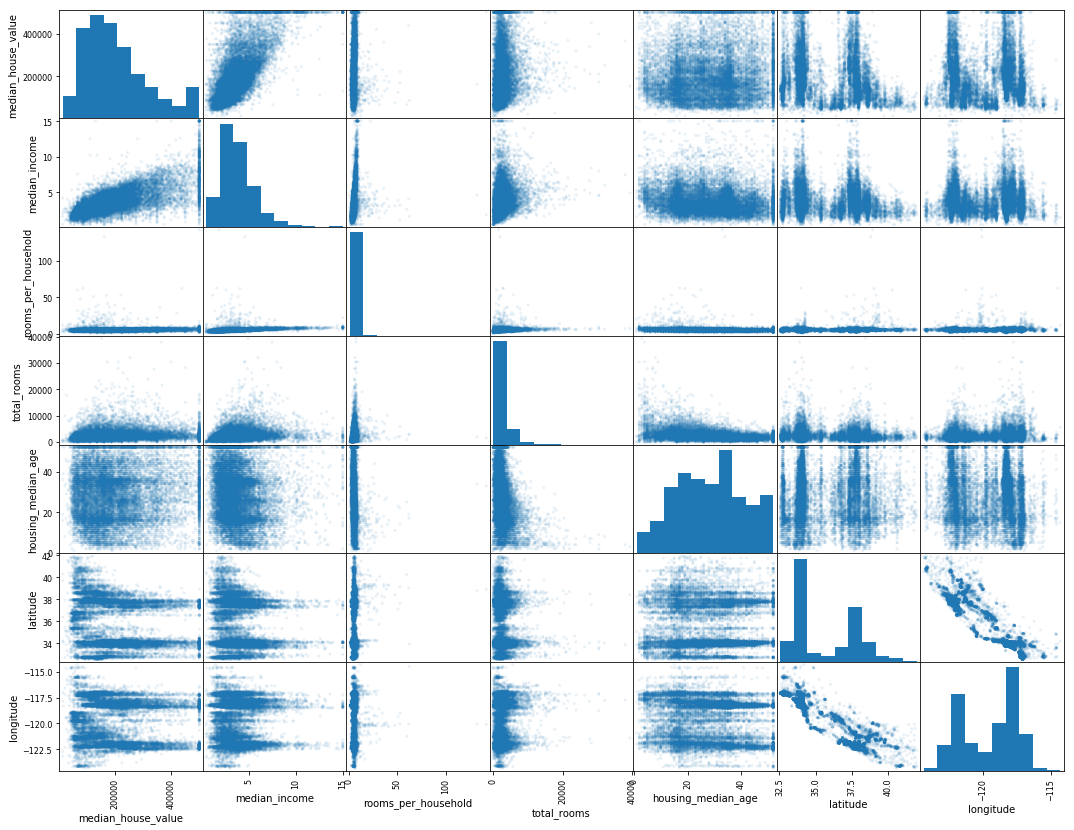

In [17]:
scatter_variables = [
    'median_house_value', 
    'median_income',
    'rooms_per_household',
    'total_rooms',
    'housing_median_age',
    'latitude',
    'longitude'
]

splot = pd.plotting.scatter_matrix(
    train_data[scatter_variables], figsize=(18, 14), alpha=0.1)